# Library

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from google.colab import files
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data

Since the Government fails to provide a complete and open dataset for disease status in the country, several young doctors in Myanmar volunteered on their own to monitor announcements. Current data applied is based on collection by Dr. Nyein Chan Ko Ko.

In [13]:
data = "https://raw.githubusercontent.com/finerbrighterlighter/myanmar_covid19/master/mohs_announcement.csv"
df = pd.read_csv(data,header= 0)
df.insert(loc=0, column="case_id", value=np.arange(1,len(df)+1))
df["case_id"] = "case_" + df["case_id"].astype(str)
df["first_date"] = pd.to_datetime(df["first_date"])
df["qua_date"] = pd.to_datetime(df["qua_date"])
df["ann_date"] = pd.to_datetime(df["ann_date"])
df["ann_date"] = pd.to_datetime(df["ann_date"])
df["exp_date"] = pd.to_datetime(df["exp_date"])
df

,case_id,age,sex,travel,region,first_date,qua_date,ann_date,exp_date
0,case_1,36,Male,United States,Chin,2020-03-13,2020-03-21,2020-03-23,NaT
1,case_2,26,Male,United Kingdom,Yangon,2020-03-22,2020-03-23,2020-03-23,NaT
2,case_3,26,Male,United Kingdom,Yangon,2020-03-21,2020-03-23,2020-03-25,NaT
3,case_4,33,Male,United States of America,Yangon,2020-03-19,2020-03-25,2020-03-27,NaT
4,case_5,69,Male,Australia -> Singapore,Yangon,2020-03-14,2020-03-25,2020-03-27,2020-03-31
5,case_6,29,Male,United Kingdom,Yangon,2020-03-21,2020-03-26,2020-03-28,NaT
6,case_7,58,Female,Switzerland,Nay Pyi Taw,2020-03-18,2020-03-26,2020-03-28,NaT
7,case_8,60,Female,NaN,Yangon,2020-03-25,2020-03-26,2020-03-28,NaT
8,case_9,44,Male,Thailand,Yangon,2020-03-23,2020-03-26,2020-03-29,NaT
9,case_10,45,Male,NaN,Yangon,2020-03-28,2020-03-28,2020-03-29,NaT


- travel -> travel history
- region -> states and admininstrative regions of Myanmar where the case is quarantined
- first_date -> entry into the country, or first symptom for no travel history
- qua_date -> first date of quarantine
- ann_date -> date of announcement by MOHS as positive
- exp_date -> date of patient's death

# Basic Timeline ( Total cases, Daily new cases, infection spread)

In [14]:
case_df = df[["ann_date","travel"]].copy()
case_df.columns = ["date", "travel"]

case_df["overseas_inflow"] = np.where(df["travel"].isna(), 0, 1)
case_df["local_spread"] = np.where(df["travel"].notna(), 0, 1)

case_df.drop("travel", axis=1 , inplace=True)
case_df=case_df.groupby(["date"]).sum().reset_index()
case_df["date"] = pd.to_datetime(case_df["date"])
case_df

,date,overseas_inflow,local_spread
0,2020-03-23,2,0
1,2020-03-25,1,0
2,2020-03-27,2,0
3,2020-03-28,2,1
4,2020-03-29,1,1
5,2020-03-30,4,1
6,2020-04-01,0,1
7,2020-04-02,0,4
8,2020-04-04,1,0


In [15]:
timeline_df = pd.DataFrame(columns=["ndays","date"])
timeline_df["ndays"] = np.arange(len(pd.date_range(start=df.ann_date.min(), end=df.ann_date.max())))
timeline_df.loc[0,"date"]=df.ann_date.min()
for i in range(1,len(timeline_df)):
    timeline_df.loc[i,"date"] = timeline_df.loc[i-1,"date"] + pd.Timedelta(days=1)
    i=i+1
timeline_df["date"] = pd.to_datetime(timeline_df["date"])

timeline_df=timeline_df.merge(case_df,indicator=False,how='left')
timeline_df["overseas_inflow"].fillna(0, inplace=True)
timeline_df["local_spread"].fillna(0, inplace=True)
timeline_df["overseas_inflow"]=timeline_df["overseas_inflow"].astype(int)
timeline_df["local_spread"]=timeline_df["local_spread"].astype(int)
timeline_df["total"] = (timeline_df["overseas_inflow"]+timeline_df["local_spread"]).cumsum().astype(int)
timeline_df

,ndays,date,overseas_inflow,local_spread,total
0,0,2020-03-23,2,0,2
1,1,2020-03-24,0,0,2
2,2,2020-03-25,1,0,3
3,3,2020-03-26,0,0,3
4,4,2020-03-27,2,0,5
5,5,2020-03-28,2,1,8
6,6,2020-03-29,1,1,10
7,7,2020-03-30,4,1,15
8,8,2020-03-31,0,0,15
9,9,2020-04-01,0,1,16


## Total Case

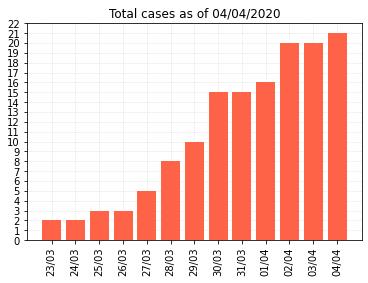

In [16]:
fig, ax = plt.subplots()
ax.grid(linestyle=':', linewidth='0.5', color='silver')
ax.set_axisbelow(True)

xindex = np.arange(len(pd.date_range(start=timeline_df.date.min(), end=timeline_df.date.max())))

plt.xticks(xindex,pd.date_range(start=timeline_df.date.min(), end=timeline_df.date.max()).strftime('%d/%m'), fontsize=10, rotation=90)
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(1))

plt.bar(xindex, timeline_df["total"], color = "tomato")

plt.title("Total cases as of "+str(timeline_df.date.max().strftime("%d/%m/%Y")))

tot_cases = str(df["ann_date"][df.index[-1]])+"_total_cases.svg"
plt.savefig(tot_cases, bbox_inches = "tight")
plt.show()
files.download(tot_cases)

## Daily New Cases

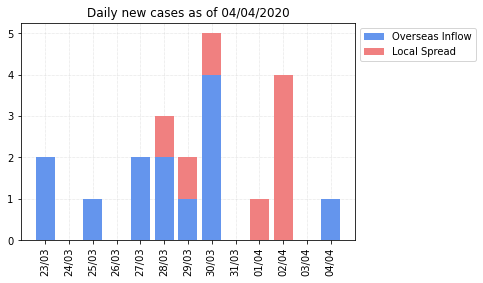

In [17]:
fig, ax = plt.subplots()
ax.grid(linestyle=':', linewidth='0.5', color='silver')
ax.set_axisbelow(True)

xindex = np.arange(len(pd.date_range(start=timeline_df.date.min(), end=timeline_df.date.max())))

plt.xticks(xindex,pd.date_range(start=timeline_df.date.min(), end=timeline_df.date.max()).strftime('%d/%m'), fontsize=10, rotation=90)
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(1))

oi_case = plt.bar(xindex, timeline_df["overseas_inflow"], color = "cornflowerblue")
ls_case = plt.bar(xindex, timeline_df["local_spread"], bottom=timeline_df["overseas_inflow"], color = "lightcoral")

plt.title("Daily new cases as of "+str(timeline_df.date.max().strftime("%d/%m/%Y")))
plt.legend((oi_case[0],ls_case[0]), ("Overseas Inflow", "Local Spread"),loc='upper left', bbox_to_anchor=(1, 1))

new_cases = str(df["ann_date"][df.index[-1]])+"_new_cases.svg"
plt.savefig(new_cases, bbox_inches = "tight")
plt.show()
files.download(new_cases)

## Spread Trend

In [18]:
spread_trend_df = pd.DataFrame(columns=["ndays","date"])
spread_trend_df["ndays"] = np.arange(len(pd.date_range(start=case_df.date.min()-pd.Timedelta(days=5), end=case_df.date.max())))
spread_trend_df.loc[0,"date"]=case_df.date.min()-pd.Timedelta(days=5)
for i in range(1,len(spread_trend_df)):
    spread_trend_df.loc[i,"date"] = spread_trend_df.loc[i-1,"date"] + pd.Timedelta(days=1)
    i=i+1
spread_trend_df["date"] = pd.to_datetime(spread_trend_df["date"])

spread_trend_df=spread_trend_df.merge(case_df,indicator=False,how='left')
spread_trend_df["overseas_inflow"].fillna(0, inplace=True)
spread_trend_df["local_spread"].fillna(0, inplace=True)
spread_trend_df["overseas_inflow"]=spread_trend_df["overseas_inflow"].astype(int)
spread_trend_df["local_spread"]=spread_trend_df["local_spread"].astype(int)
spread_trend_df["tot_overseas_inflow"]=spread_trend_df["overseas_inflow"].cumsum()
spread_trend_df["tot_local_spread"]=spread_trend_df["local_spread"].cumsum()
spread_trend_df

,ndays,date,overseas_inflow,local_spread,tot_overseas_inflow,tot_local_spread
0,0,2020-03-18,0,0,0,0
1,1,2020-03-19,0,0,0,0
2,2,2020-03-20,0,0,0,0
3,3,2020-03-21,0,0,0,0
4,4,2020-03-22,0,0,0,0
5,5,2020-03-23,2,0,2,0
6,6,2020-03-24,0,0,2,0
7,7,2020-03-25,1,0,3,0
8,8,2020-03-26,0,0,3,0
9,9,2020-03-27,2,0,5,0


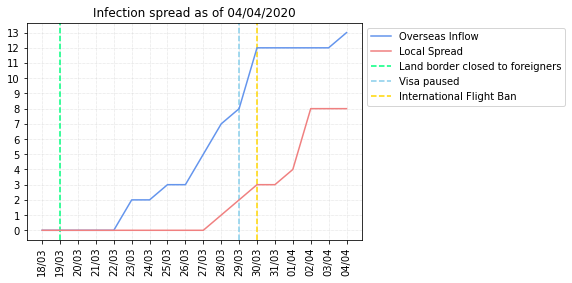

In [19]:
fig, ax = plt.subplots()
ax.grid(linestyle=':', linewidth='0.5', color='silver')
ax.set_axisbelow(True)

xindex = np.arange(len(pd.date_range(start=spread_trend_df.date.min(), end=spread_trend_df.date.max())))

plt.xticks(xindex,pd.date_range(start=spread_trend_df.date.min(), end=spread_trend_df.date.max()).strftime('%d/%m'), fontsize=10, rotation=90)
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(1))

land_close_fore = plt.axvline(x=1, color="springgreen", linestyle="--")
visa_close = plt.axvline(x=11, color="skyblue", linestyle="--")
air_close = plt.axvline(x=12, color="gold", linestyle="--")
overseas_inflow = plt.plot(xindex, spread_trend_df["tot_overseas_inflow"], color="cornflowerblue")
local_spread = plt.plot(xindex, spread_trend_df["tot_local_spread"], color="lightcoral")

plt.title("Infection spread as of "+str(spread_trend_df.date.max().strftime("%d/%m/%Y")))
plt.legend((overseas_inflow[0],local_spread[0],land_close_fore,visa_close,air_close), ("Overseas Inflow", "Local Spread","Land border closed to foreigners","Visa paused","International Flight Ban"),loc='upper left', bbox_to_anchor=(1, 1))

spread = str(df["ann_date"][df.index[-1]])+"_spread.svg"
plt.savefig(spread, bbox_inches = "tight")
plt.show()
files.download(spread)

# Per Patient Timeline

In [20]:
timeline_df = pd.DataFrame(columns=["case_id"])
timeline_df["case_id"] = df["case_id"]
timeline_df["until_qua"] = (df["qua_date"]-df["first_date"]).dt.days
timeline_df["until_ann"] = (df["ann_date"]-df["qua_date"]).dt.days
timeline_df["until_first"] = (df["first_date"]-df["first_date"].min()).dt.days
timeline_df["until_exp"] = np.where(df["exp_date"].notna(), (df["exp_date"]-df["ann_date"]).dt.days, 0)
timeline_df["until_dsc"] = np.where(df["exp_date"].isna(), (pd.to_datetime("now")-df["ann_date"]).dt.days, 0)
timeline_df

,case_id,until_qua,until_ann,until_first,until_exp,until_dsc
0,case_1,8,2,0,0.0,13
1,case_2,1,0,9,0.0,13
2,case_3,2,2,8,0.0,11
3,case_4,6,2,6,0.0,9
4,case_5,11,2,1,4.0,0
5,case_6,5,2,8,0.0,8
6,case_7,8,2,5,0.0,8
7,case_8,1,2,12,0.0,8
8,case_9,3,3,10,0.0,7
9,case_10,0,1,15,0.0,7


##Timeline for each patient(Bar Plot)

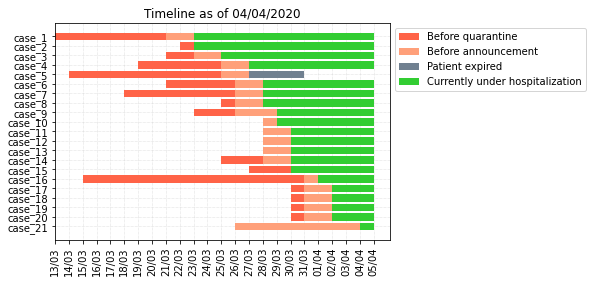

In [21]:
fig, ax = plt.subplots()
ax.grid(linestyle=':', linewidth='0.5', color='silver')
ax.set_axisbelow(True)

yindex = np.arange(len(timeline_df["case_id"]))
xindex = np.arange(len(pd.date_range(start=df.first_date.min(), end=pd.to_datetime("now"))))

plt.yticks(yindex,timeline_df["case_id"], fontsize=10)
plt.xticks(xindex,pd.date_range(start=df.first_date.min(), end=pd.to_datetime("now")).strftime('%d/%m'), fontsize=10, rotation=90)
plt.gca().invert_yaxis()

until_qua = plt.barh(yindex, timeline_df["until_qua"], left= timeline_df["until_first"], color = "tomato")
until_ann = plt.barh(yindex, timeline_df["until_ann"], left= timeline_df["until_qua"]+timeline_df["until_first"], color = "lightsalmon")
until_exp = plt.barh(yindex, timeline_df["until_exp"], left= timeline_df["until_ann"]+timeline_df["until_qua"]+timeline_df["until_first"], color = "slategray")
until_dsc = plt.barh(yindex, timeline_df["until_dsc"], left= timeline_df["until_exp"]+timeline_df["until_ann"]+timeline_df["until_qua"]+timeline_df["until_first"], color = "limegreen")

plt.title("Timeline as of "+str(df.ann_date.max().strftime("%d/%m/%Y")))
plt.legend((until_qua[0], until_ann[0],until_exp[0],until_dsc[0]), ("Before quarantine", "Before announcement","Patient expired","Currently under hospitalization"),loc='upper left', bbox_to_anchor=(1, 1))

timeline = str(df["ann_date"][df.index[-1]])+"_timeline.svg"
plt.savefig(timeline, bbox_inches = "tight")
plt.show()
files.download(timeline)

##Time taken for action (Bar Plot)

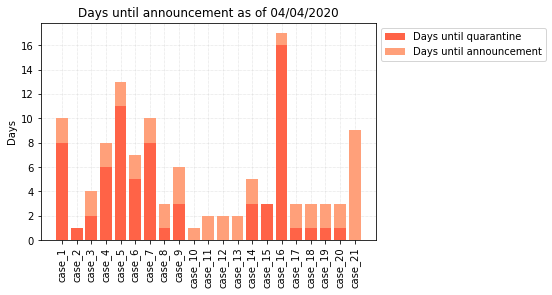

In [22]:
fig, ax = plt.subplots()
ax.grid(linestyle=':', linewidth='0.5', color='silver')
ax.set_axisbelow(True)

index = np.arange(len(timeline_df["case_id"]))

p1 = plt.bar(index, timeline_df["until_qua"], color = "tomato")
p2 = plt.bar(index, timeline_df["until_ann"], bottom=timeline_df["until_qua"], color = "lightsalmon")

plt.ylabel("Days", fontsize=10)
plt.title("Days until announcement as of "+str(df.ann_date.max().strftime("%d/%m/%Y")))
plt.xticks(index,timeline_df["case_id"], fontsize=10, rotation=90)
plt.legend((p1[0], p2[0]), ("Days until quarantine", "Days until announcement"),loc="upper left", bbox_to_anchor=(1, 1))

days = str(df["ann_date"][df.index[-1]])+"_time_for_action.svg"
plt.savefig(days, bbox_inches = "tight")
plt.show()
files.download(days)